# Construction d'un système de recommandation

Nous avons décidé d'orienter notre projet sur la recommendation de films.
En effet durant ce confinement, nous avons eu le temps de visionner beaucoup de films,
mais nous nous sommes rendus compte que nous passions quasiment autant de temps
à choisir le film qu'à le regarder. D'où la nécessité de créer un système de re-
commendations afin d'optimiser notre temps de visionnage.
Nous avons chercher une base de données assez exploitable afin de mener à bien
notre projet. Nous nous sommes basés sur la base de données de 'The Movies Dataset'.

# Différents systèmes de recommandation

- [x] popularity based = moyenne simple
- [x] memory-based (user- et item- based)
- [x] hybride : popularity/collabo
- [x] clustering
- [ ] hybride : cluster/collabo
- [ ] model-based (matrix factorisation, optimisation avec descente de gradient)
    - [x] descente de gradient
    - [ ] cross-validation pour tuner les hyperparamètres
- [ ] hybride : cluster/model
- [ ] user-centered linear approach = descente de gradient (même pb d'opti que model-based, mais on donne les infos des films)


In [133]:
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import re
from time import time
from ast import literal_eval

In [18]:
%load_ext line_profiler

ModuleNotFoundError: No module named 'line_profiler'

## Fetching and cleaning data

Nous utilisons deux tables de données. L'une, *movies_metadata.csv*, contient une liste de films et des informations relativesau genre, date de sortie etc. 

In [79]:
movies = pd.read_csv("movies_metadata.csv")
ratings = pd.read_csv("ratings_small.csv")
keywords = pd.read_csv("keywords.csv")
credits = pd.read_csv("tmdb_5000_credits.csv")
link = pd.read_csv("links_small.csv")

In [80]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [81]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [82]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [83]:
# don't re-run
movies = movies[~movies.id.duplicated()]
movies.id = movies.id.apply(filter_correct_id)
movies = movies[movies.id != "wrong_id"]
movies.id = movies.id.astype('int64')

### Avis des utilisateurs

In [84]:
ratings = pd.read_csv("ratings_small.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [85]:
# ne pas re-run !
ratings = ratings.drop(columns=['timestamp'])
ratings.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [86]:
ratings[(ratings['userId'] == 1) & (ratings['movieId'] == 31)]

,userId,movieId,rating
0,1,31,2.5


In [87]:
print(min(ratings.rating), max(ratings.rating))
ratings.describe()
ratings.dtypes

0.5 5.0


userId       int64
movieId      int64
rating     float64
dtype: object

Dans tout le notebook, on considère l'existence d'une variable globale `dfr` contenant la dataframe des notes et `dfm` contenant la dataframe des films. Cela nous permet d'abord tester notre code sur des petits échantillons et avant de les faire tourner sur la totalité des donneés, sans avoir à modifier le code. De même,

## Top films par genres

### Selection des genres

In [10]:
dfr = ratings.copy()
dfm = movies.copy().rename(columns={'id' : 'movieId'})
dfm = dfm.merge(dfr, how='inner')
dfm = dfm.loc[:, ['movieId', 'genres', 'title']]
dfm.head()
# dfm.sort_values(by='movieId').head(100)
# dfr.head(20)

,movieId,genres,title
0,949,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",Heat
1,949,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",Heat
2,949,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",Heat
3,949,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",Heat
4,949,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",Heat


In [11]:
def simplify_genre(l):
    if len(l) <= 0 :
        return []
    if isinstance(l[0], dict):
        return [d['name'] for d in l]
    return l

dfm['genres'] = dfm['genres'].apply(lambda x: literal_eval(x) if isinstance(x, str) else x).apply(simplify_genre)
dfm.head()

,movieId,genres,title
0,949,"[Action, Crime, Drama, Thriller]",Heat
1,949,"[Action, Crime, Drama, Thriller]",Heat
2,949,"[Action, Crime, Drama, Thriller]",Heat
3,949,"[Action, Crime, Drama, Thriller]",Heat
4,949,"[Action, Crime, Drama, Thriller]",Heat


### Normaliser les notes sur toutes les données

In [12]:
%timeit dfm['mean_rating'] = ratings.groupby('movieId').mean().loc[:, ['rating']]

20.6 ms ± 2.35 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
dfm.head()

,movieId,genres,title,mean_rating
0,949,"[Action, Crime, Drama, Thriller]",Heat,NaN
1,949,"[Action, Crime, Drama, Thriller]",Heat,3.872470
2,949,"[Action, Crime, Drama, Thriller]",Heat,3.401869
3,949,"[Action, Crime, Drama, Thriller]",Heat,3.161017
4,949,"[Action, Crime, Drama, Thriller]",Heat,2.384615


In [14]:
dfm = dfm.sort_values(by='mean_rating', ascending=False)

In [15]:
dfm.head()

,movieId,genres,title,mean_rating
702,1945,"[Drama, Thriller]",Nell,5.0
4711,1092,"[Thriller, Mystery]",The Third Man,5.0
32515,920,"[Animation, Adventure, Comedy, Family]",Cars,5.0
3202,3083,"[Comedy, Drama]",Mr. Smith Goes to Washington,5.0
32460,588,"[Horror, Mystery]",Silent Hill,5.0


# <span style="color:green">copy de dfm + join pour que mean_rating soit respecté + ou ne pas faire de repetition et utiliser deux tables ? </span>

In [19]:
# 1 genre par ligne
serie = dfm.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
serie.name = 'genres'
dfm_simpl = dfm.copy().drop('genres', axis=1).join(serie)
dfm_simpl.head()

,movieId,title,mean_rating,genres
0,949,Heat,NaN,Action
0,949,Heat,NaN,Crime
0,949,Heat,NaN,Drama
0,949,Heat,NaN,Thriller
1,949,Heat,3.87247,Action


In [ ]:
def top(genres):
    # selection des films par genre
    df_genres = dfm_simpl.loc[dfm_simpl['genre'].isin(genres)]
    df_genres = df_genres.sort_values(by='mean_rating', ascending=False)
    return df_genres

In [ ]:
top(['Drama', 'Comedy']).head()

In [ ]:
def union_list(lst1, lst2):
    return list(set(lst1) | set(lst2)) 

def pref_genres(uid):
    '''
    Retourne les genres des 5 films préférés de l'user uid
    '''
    rats = dfr.loc[dfr['userId'] == uid, :].sort_values(by='rating')
    pref = rats.head(5)['movieId'].values if rats.shape[0] > 5 else rats['movieId'].values
    genres = []
    for g in dfm.loc[dfm['movieId'].isin(pref)].genres :
        genres = union_list(genres, g)
    return genres

In [ ]:
def top_reco(uid, k):
    '''
    Retourne les k films les plus populaires appartenant aux genres préféres de l'user uid
    '''
    chart = top(pref_genres(uid))
    chart = chart.loc[~chart['movieId'].isin(dfr.loc[dfr['userId'] == uid, :].movieId.unique()) ]
    return chart.head(k) if chart.shape[0] > k else chart

In [ ]:
user = 4
k = 15

print(pref_genres(user))
top_reco(user, k)

# GRAPHES

- [x] graphe 'scatter' vote_average par rapport vote_count
- [ ] graphe 'pie' sur l'original_language (need groupby and count)
- [ ] graphe 'bar' année de sortie et vote_average
- [ ] graphe avec le runtime ...
- rajouter d'autres idées


In [134]:
import seaborn as sns
sns.set()

In [118]:
 test = movies.loc[:, [ 'title', 'original_language','production_countries','release_date','vote_average']]

/Users/emmacovili/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/emmacovili/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/emmacovili/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/emmacovili/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/emmacovili/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) 

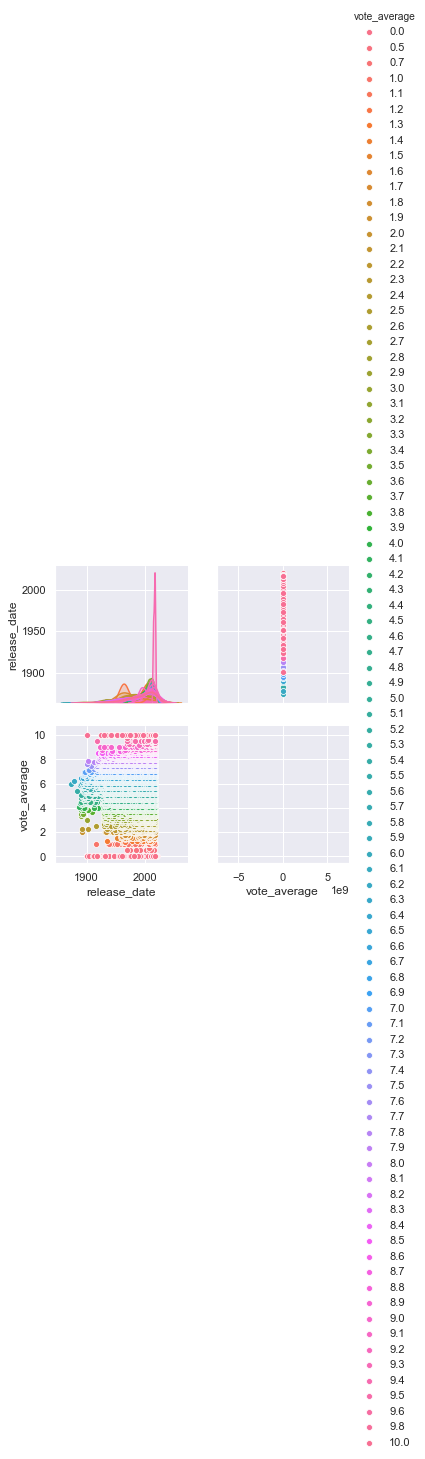

In [135]:
sns.pairplot(test,hue='vote_average')

In [125]:
test.release_date = test.release_date.apply(simplify_date)
test.production_countries = test.production_countries.apply(simplify_countries)

In [126]:
test.head()

,title,original_language,production_countries,release_date,vote_average
0,Toy Story,en,[US],1995.0,7.7
1,Jumanji,en,[US],1995.0,6.9
2,Grumpier Old Men,en,[US],1995.0,6.5
3,Waiting to Exhale,en,[US],1995.0,6.1
4,Father of the Bride Part II,en,[US],1995.0,5.7


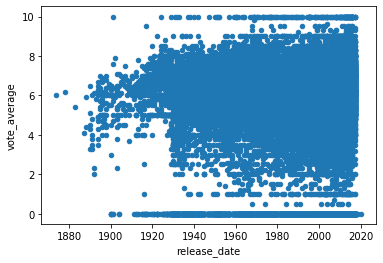

In [130]:
# Objectif --> graphes de la moyenne des notes des films sur l'année
# Try Split-apply-combine Method

test.plot(x='release_date', y='vote_average', kind = 'scatter')
plt.show()

In [190]:
# pie graphe sur les langues originales des films (pour établir une proportion)

test_by_original_language = test.groupby('original_language')
print(test_by_original_language)

language_count = test_by_original_language['title'].count()
print(language_count)


y = test['original_language'].unique()
print(y)
print(len(y))



original_language
ab     10
af      2
am      2
ar     39
ay      1
     ... 
vi     10
wo      5
xx     33
zh    409
zu      1
Name: title, Length: 89, dtype: int64
['en' 'fr' 'zh' 'it' 'fa' 'nl' 'de' 'cn' 'ar' 'es' 'ru' 'sv' 'ja' 'ko'
 'sr' 'bn' 'he' 'pt' 'wo' 'ro' 'hu' 'cy' 'vi' 'cs' 'da' 'no' 'nb' 'pl'
 'el' 'sh' 'xx' 'mk' 'bo' 'ca' 'fi' 'th' 'sk' 'bs' 'hi' 'tr' 'is' 'ps'
 'ab' 'eo' 'ka' 'mn' 'bm' 'zu' 'uk' 'af' 'la' 'et' 'ku' 'fy' 'lv' 'ta'
 'sl' 'tl' 'ur' 'rw' 'id' 'bg' 'mr' 'lt' 'kk' 'ms' 'sq' nan 'qu' 'te' 'am'
 'jv' 'tg' 'ml' 'hr' 'lo' 'ay' 'kn' 'eu' 'ne' 'pa' 'ky' 'gl' 'uz' 'sm'
 'mt' 'hy' 'iu' 'lb' 'si']
90


ValueError: 'label' must be of length 'x'

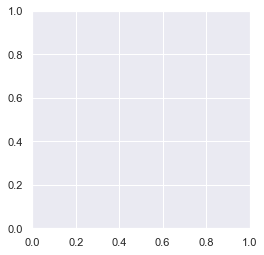

In [180]:
fig, ax = plt.subplots()
ax.pie(x, labels=y, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')

plt.show()

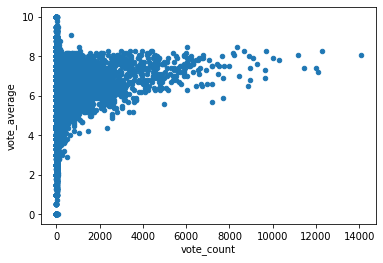

In [26]:
movies.plot(x='vote_count', y='vote_average', kind='scatter')
plt.show()

# <span style="color:red"> À blablater : méthode pas personalisée, privilégie les plus populaires et ne permet pas d'évaluer de manière quantitative la pertinence (pas de note)
</span>

## Collaborative filtering : user- et item- based

Pour prédire la note d'un couple (*user*, *movie*) on peut regarder quelle note les utilisateurs similaires à *user* ont donné à ce film et faire une moyenne de leurs notes. On peut également regarder quelle note *user* a donné à des films similaires à *movie*. La première approche est centré sur les utilisateurs, *user-based*, tandis que la deuxième est centrée sur les films, *item-based*. Neánsmoins les deux approches suivent la même logique et nous allons implémenter des fonctions qui s'adaptent en fonction de l'approche choisie. Dans un système *user-based*, nous allons appeler **peers** les **users** et **others** les **items**. Dans un système *item-based* c'est l'inverse.



Deux utilisateurs sont considérés comme similaires s'ils ont les mêmes préférences de films. Il semble en effet plus pertinent de demander à un utilisateurs aux goûts similaires à *user* de lui conseiller un film. Pour comparer deux utilisateurs il faudra donc regarder les notes qu'ils ont donné aux mêmes films. De manière analogue, deux films sont similaires s'ils sont appréciés par les mêmes utilisateurs. Il faudra donc regarder les notes données par les mêmes utilisateurs pour comparer deux films. Cette notion de similitude sera calculée par un taux de corrélation.

Nous allons considérer une variable globale `cm_user` et `cm_movie` contenant la matrice de correlation entre utilisateurs et films. 

### Normalisation des notes

Nous n'avons besoin pour ce système que des notes données par les utilisateurs. Puisque la moyenne des notes données varie d'un utilisateur à un autre et d'un film à un autre, nous allons translater les notes afin que la moyenne des notes se trouve à 0. En *user-based*, on considère la moyenne par utilisateur, tandis qu'en *item-based* on s'interèsse à la moyenne par film. Par abus de langage nous appelons ces nouvelles notes les notes *normalisées*. 

In [ ]:
# test si plus efficace 
# _ mean une dataframe, et donc récuper la note moyenne avec un loc
# _ mean un numpy matrice, avec une liste donnant l'équivalent entre id et indice

dfr = ratings.copy().loc[(ratings['userId'] <= 50) & (ratings['movieId'] <= 500)]
base ='user'
ptype, otype = ('userId', 'movieId') if base == 'user' else ('movieId', 'userId')
print(dfr.shape)
dfr.head()

In [ ]:
%%timeit
mean1 = dfr.groupby(ptype).mean().loc[:, ['rating']]
new_col = 'rating_norm_'+base
dfr[new_col] = dfr[[ptype, 'rating']].apply(lambda row : 
                                            row['rating'] -  mean1.loc[int(row[ptype])]['rating'], axis=1)

In [ ]:
%%timeit
mean2 = dfr.groupby(ptype).mean()['rating']
new_col = 'rating_norm_'+base
dfr[new_col] = dfr[[ptype, 'rating']].apply(lambda row : 
                                            row['rating'] -  mean2.loc[int(row[ptype])], axis=1)

In [ ]:
def normalize(base='user'):
    '''
    Ajoute une colonne dans la dataframe df contenant les notes normalisées des utilisateurs
    Retourne la Série donnant la moyenne des notes par peer
    '''
    ptype, otype = ('userId', 'movieId') if base == 'user' else ('movieId', 'userId')
    mean = dfr.groupby(ptype).mean()['rating']
    new_col = 'rating_norm_'+base
    dfr[new_col] = dfr[[ptype, 'rating']].apply(lambda row : 
                                            row['rating'] -  mean.loc[int(row[ptype])], axis=1)
    return mean

### Calculer la matrice de corrélation


Dans un système *user-based*, on note $I_u$ l'ensemble des items renseignés pour l'utilisateur $u$ et $U_k$ l'ensemble des utilisateurs qui ont notés le film $k$. On note $I_{uv} = I_u \cap I_v$. Pour le *item-based* on utilisera les mêmes notations en intervertissant user et item. On notera également $S_{ui}$ la note normalisée de l'item *i* donnée par l'utilisateur *u*. 


Pour déterminer si deux utilisateurs se ressemblent en termes de goûts, nous utilisons un taux de corrélation sur les avis données. Nous allons comparer quatres taux de corrélations différents. Le premier ```cor()``` calcule le taux de corrélation classique donné par la formule :
$$
cor(u, v) = \frac{\sum_{k \in I_{uv}} s_{uk} s_{vk}}{\sqrt{\sum_{k \in I_{uv}} s_{uk}^2}\sqrt{\sum_{k \in I_{uv}} s_{vk}^2}}
$$

Le taux de corrélation ajusté ```cor_adj()``` permet de ne pas donner trop d'importance aux films populaires que beaucoup de personnes ont vu.
$$
cor\_adj(u, v) = \frac{\sum_{k \in I_{uv}} s_{uk} s_{vk} / U_k}{\sqrt{\sum_{k \in I_{uv}} \frac{s_{uk}^2}{|U_k|}}\sqrt{\sum_{k \in I_{uv}} \frac{s_{vk}^2}{|U_k|}}}
$$

Le taux de correlation calculé par ```cor_dis()``` permet de ne pas donner une correlation trop élevée si les deux utilisateurs n'ont pas donné assez d'avis sur des films en commun. 
$$
cor\_dis(u, v) = cor(u, v) * \frac{min(|I_{uv}|, \beta)}{\beta}
$$

Enfin la fonction ```cor_dis_adj()``` fait un mélange des deux dernières amélioration : il filtre les films trop populaire et n'apporte de l'importance seulement si deux personnes ont données leur avis sur un certain nombre de films.

$$
cor\_dis(u, v) = cor\_adj(u, v) * \frac{min(|I_{uv}|, \beta)}{\beta}
$$

# <span style="color:red">Big question : on donne quoi comme correlation si su et/ou sv est nul ? J'ai mis 0 par défaut mais bon ...
</span>

In [ ]:
def tx_cor(u, v, base):
    '''
    :param: u, v - les id des peers (user ou movie) à comparer
            base - un indicateur dy type de recommandation utilisé : 'user' ou 'movie'
    :return: le taux de corrélation classique entre u et v.
    '''
    ptype, otype = ('userId', 'movieId') if base == 'user' else ('movieId', 'userId')
    
    Iu = dfr.loc[dfr[ptype] == u, [otype]]
    Iv = dfr.loc[dfr[ptype] == v, [otype]]
    Iuv = Iu.join(Iv.set_index(otype), on=otype, how='inner')
    if not Iuv.shape[0] : # l'intersection est vide
        return float('nan')

    su = dfr.loc[(dfr[ptype] == u) & (dfr[otype].isin(Iuv[otype]))]
    sv = dfr.loc[(dfr[ptype] == v) & (dfr[otype].isin(Iuv[otype]))]
    su = su['rating_norm_'+base].to_numpy()
    sv = sv['rating_norm_'+base].to_numpy()
    
    up = np.dot(su, sv)
    down = math.sqrt(np.dot(su, su) * np.dot(sv, sv))

# default value to change
    if up == 0 or down == 0:
        return 0
    return up / down

# <span style="color:red">À adapter encore</span>

In [ ]:
def cor_adj(u, v, df, Iuv):
    nb_rat = df.loc[:, ['movieId', 'rating']].groupby(['movieId']).count()
    
    sum_up = 0
    sum_down_u = 0
    sum_down_v = 0
    for movie in Iuv.movieId.unique() :
        suk = df.loc[(df['userId'] == u) & (df['movieId'] == movie), ['rating_norm_'+base]]
        svk = df.loc[(df['userId'] == v) & (df['movieId'] == movie), ['rating_norm_'+base]]
        suk, svk = float(suk), float(svk)
        
        sum_up += suk * svk / nb_rat.at[movie, 'rating']
        sum_down_u += suk**2 /  nb_rat.at[movie, 'rating']
        sum_down_v += svk**2 /  nb_rat.at[movie, 'rating']
    return sum_up / math.sqrt(sum_down_u * sum_down_v)

In [ ]:
def cor_dis(u, v, df, Iuv):
    beta = 20
    correlation = cor(u, v, df, Iuv)
    return correlation * min(len(Iuv), beta)/beta

In [ ]:
def cor_dis_adj(u, v, df, Iuv):
    beta = 20
    correlation = cor_adj(u, v, df, Iuv)
    return correlation * min(len(Iuv), beta)/beta

# <span style="color:red">Big question 2 : un gars ([ici](https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/)) fait cette fonction pour calculer la matrice plus rapidement </span>


In [ ]:
def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

Nous construisons maintenant la matrice de correlation. Puisqu'une telle matrice est symétrique, nous avons préféré utiliser une dataframe à deux entrées et ainsi ne stocker la corrélation pour un couple qu'une seule fois. En procédant comme tel, l'ordre dans lequel on désigne un couple peer-peer sera important. Pour faciliter l'accès, nous trions d'abord la datframe `df` pour que les peers soient pris dans l'ordre croissant des id. Ainsi les doubles indices de la dataframe construite auront tous la propriété que le premier indice est strictement inférieur au deuxième. Lors de l'accès à la correlation entre deux peers *u et v* il suffira de les ranger dans le bon ordre.

La fonction de corrélation à utiliser peut être précisée en argument et par défaut la fonction choisie est la corrélation classique.

Nous utilisons également le module logging pour suivre le déroulement du calcul. Celui-ci peut être très long en fonction de la taille des données et en rappelant tous les 10 peers qu

Comme le calcul de la matrice peut-être très long, afin d'voir un suivi du déroulement du calcul, on utilise le module logging. Cette fonctionalité est désactivée par défaut. 

# <span style="color:green">Comparer temps de construction d'une matrice de corrélation vs dataframe de corrélation. Dans construction de matrice, peut-être checker si déjà calculer et recuperer dans cellule déjà entrée ? Ou est ce plus long que de juste recalculer le taux de corrélation ? ==> timer le calcul d'une correlation </span>

In [ ]:
dfr = ratings.copy().loc[(ratings['userId'] <= 50) & (ratings['movieId'] <= 500)]
print(dfr.shape)
base ='user'
user = 2
movie = 4

mean_user = normalize(base)

In [ ]:
%timeit cor(u, v, base)
%timeit 3 + 4

In [ ]:
%timeit peers = dfr.userId.unique() if base == 'user' else dfr.movieId.unique()

In [ ]:
%timeit peers = dfr[base+'Id'].unique()

In [ ]:
%timeit cm_user = slow_cor_matrix(base='user')

In [ ]:
%timeit cm_user, user_rank = cor_matrix(base='user')

In [ ]:
%%timeit
global cm_user
global user_rank
cm_user = slow_cor_matrix(base='user')
a = slow_get_cor(u, v, base)

In [ ]:
%%timeit
global cm_user
global user_rank
cm_user, user_rank = cor_matrix(base='user')
a = get_cor(u, v, base)

In [ ]:
def slow_cor_matrix(cor_fct=tx_cor, base='user', verbose=False):
    '''
    Retourne la dataframe des taux de corrélations entre peers
    '''
    ptype, otype = ('userId', 'movieId') if base == 'user' else ('movieId', 'userId')
    dfr.sort_values(by=ptype, inplace=True)
    peers = dfr[base+'Id'].unique()
    nb_peers = len(peers)
    
    if verbose:
        logger = logging.getLogger()
        logger.setLevel(logging.INFO)
        logging.info('nb of peers: {}'.format(nb_peers))
    
    correlation = []
    couples = []
    for i in range(nb_peers):
        u = peers[i]
        if verbose and not i % 10 : 
            logging.info('peer nb: {} (id {})'.format(i, u))
        for j in range(i + 1, nb_peers):
            v = peers[j]
            tx_cor = cor_fct(u, v, base)
            if not np.isnan(tx_cor):
                couples.append((u, v))
                correlation.append(tx_cor)
    index = pd.MultiIndex.from_tuples(couples, names=['u', 'v'])
    cor = pd.DataFrame(correlation, index=index, columns=['correlation'])
    return cor

In [ ]:
def slow_get_cor(u, v, base='user'):
    '''
    Retourne le taux de correlation entre u et v stocké
    '''
    cm = cm_user if base == 'user' else cm_movie
    if u > v :
        u, v = v, u
    index = list(cm.index.values)
    if (u, v) in index :
#         print('here')
        return float(cm.loc[(u, v)])
    return float('nan')

In [ ]:
def cor_matrix(cor_fct=tx_cor, base='user', verbose=False):
    '''
    Retourne la matrice de corrélation entre peers
    '''
    ptype, otype = ('userId', 'movieId') if base == 'user' else ('movieId', 'userId')
    dfr.sort_values(by=ptype, inplace=True)
    peers = dfr[base+'Id'].unique()
    nb_peers = len(peers)
    
    if verbose:
        logger = logging.getLogger()
        logger.setLevel(logging.INFO)
        logging.info('nb of peers: {}'.format(nb_peers))
    
    cor = np.empty((nb_peers,nb_peers))
    cor[:] = np.nan

    for i in range(nb_peers):
        u = peers[i]
        if verbose and not i % 10 : 
            logging.info('peer nb: {} (id {})'.format(i, u))
        for j in range(i + 1, nb_peers):
            v = peers[j]
            tx_cor = cor_fct(u, v, base)
            if not np.isnan(tx_cor):
                cor[i, j] = tx_cor
                cor[j, i] = cor[i, j]
    return cor, peers

In [ ]:
def get_cor(u, v, base='user'):
    '''
    Retourne le taux de correlation entre u et v
    '''
    cm = cm_user if base == 'user' else cm_movie
    id_index = user_rank if base == 'user' else movie_rank
    idu, idv = np.argwhere(id_index == u)[0, 0], np.argwhere(id_index == v)[0, 0]
    return cm[u, v]

### Prédiction

Pour prédire la note donnée par un utilisateur à un film, nous allons faire un moyenne des notes données pour les k peer les plus proches. Dans une approche user-based, on regarde donc les k plus proches utilisateurs, dans une approche item-based, les k films les plus proches. Les plus proches sont ceux qui ont une corrélation la plus élevée. On appelle **p** le peer et **o** l'élément other.

La moyenne effectuée est pondérée par les coefficients de corrélations. On ajoute également la moyenne des notes de **p** pour retrouver une note non normalisée.


$$
\hat{\sigma}_{um} = \mu_u + \frac{\sum_{v \in P_u(m)} s_{vm} \cdot cor(u, v)}{\sum_{v \in P_u(m)} |cor(u,v)|}
$$

# <span style="color:red">Pourquoi utiliser un parsing fait maison et pas knn non parametré comme tout le monde sur internet ?</span>

In [ ]:
def peer_group(p, o, base='user', k=4):
    '''
    Retourne les k peers les plus proches de p
    '''
    ptype, otype = ('userId', 'movieId') if base == 'user' else ('movieId', 'userId')
    
    # in user-based, get users that rated the movie o
    peers = dfr.loc[dfr[otype] == o, [ptype, 'rating_norm_'+base]]
    peers = peers[base+'Id'].unique()
    
    top = [(float('-inf'), p)] * k
    for v in peers:
        taux = get_cor(p, v, base)
        if taux > top[-1][0] :
            top += [(taux, v)]
            top.sort(reverse=True)
            top = top[:-1]
    return [t[1] for t in top]

# <span style="color:red">Que faire si sum_dow == 0 ? + prédire une note possible ?</span>

In [ ]:
def predict_collabo(p, o, base='user', k=4):
    '''
    Retourne la prédiction de la note du couple (p, o) utilisant un peer-groupe de taille k
    '''
    ptype, otype = ('userId', 'movieId') if base == 'user' else ('movieId', 'userId')

    mu = mean_user[p] if base == 'user' else mean_movie[p]
    peers = peer_group(p, o, base, k)
    
    sum_up, sum_down = 0, 0
    for friend in peers:
        cor = get_cor(p, friend, base)
        if not math.isnan(cor):
            sfo = dfr.loc[(dfr[ptype] == friend) & (dfr[otype] == o), 'rating_norm_'+base]
            sfo = 0 if len(sfo) <= 0 else float(sfo)
            sum_up += sfo * cor
            sum_down += abs(cor)

    sum_down = 1 if sum_down == 0 else sum_down
    pred = mu + sum_up / sum_down
    
    # note prédite à une précision de 0.5
    pred = round(2 * pred) / 2
    # note prédite se trouve entre 0 et 5
    pred = 5 if pred > 5 else pred
    pred = 0 if pred < 0 else pred

    return pred

### Test des fonctions de manière individuelle

In [ ]:
dfr = ratings.copy().loc[(ratings['userId'] <= 30) & (ratings['movieId'] <= 500)]
print(dfr.shape)
dfr.head()

In [ ]:
%timeit normalize('user')

In [ ]:
dfr.head()

In [ ]:
dfr.shape

In [ ]:
normalize('movie')
normalize('user')
dfr.head()

In [ ]:
cm_user = slow_cor_matrix(base='user', verbose=True)

In [ ]:
cm_user.head()

In [ ]:
%timeit cm_user = cor_matrix(base='user', verbose=True)

In [ ]:
cm_user = cor_matrix(base='user', verbose=True)
cm_user.head()

In [ ]:
%timeit cm_movie = slow_cor_matrix(base='movie', verbose=True)

In [ ]:
%timeit cm_movie = cor_matrix(base='movie', verbose=True)
cm_movie.head()

In [ ]:
user = 4
movie = 49280
movie2 = 26791

p1 = predict_collabo(user, movie, base='user')
p2 = predict_collabo(user, movie, base='movie')
p3 = predict_collabo(user, movie2, base='user')
p4 = predict_collabo(user, movie2, base='movie')
print(p1)
print(p2)
print(p3)
print(p4)

# <span style="color:red"> Hypothèse sur pourquoi c'est pas différent (en haut) : pas assez de données. Parce que quand on utilise tout le datase (en bas) ça marche ... ?
</span>.

### Utilisation de toutes les données

In [ ]:
dfr = ratings

In [ ]:
%timeit normalize(base='user')
dfr.head()

In [ ]:
%timeit normalize(base='movie')
dfr.head()

In [ ]:
t1 = time()
cm_user = cor_matrix(base='user', verbose=True)
t2 = time()
print(t2-t1)
cm_user.head()

In [ ]:
t1 = time()
cm_movie = cor_matrix(base='movie', verbose=True)
t2 = time()
print(t2-t1)
cm_movie.head()

In [ ]:
user = 3
movie = 4
movie2 = 5765

p1 = predict_collabo(user, movie, base='user')
# p2 = predict_collabo(k, user, movie, base='movie')
p3 = predict_collabo(user, movie2, base='user')
print(p1)
# print(p2)
print(p3)

## Modèle hybride : popularité par genre et collaborative filtering

La méthode précédente permet de prédire une note, mais nous aimerions pouvoir recommander des films à un utilisateurs qu'il est susceptible d'aimer. Pour cela il faudrait prédire la note qu'il donnerait à tous les films qu'il n'a pas encore noté et prélever ceux dont la note prédite est la plus élevée. Ceci serait beaucoup trop coûteux. Une première solution est de ne considérer que des films appartenant à ses genres préférés. Ceci risque d'être toujours trop coûteux, alors nous allons nous restreindre qu'aux films les plus populaires dans ses genres préférés.

# <span style="color:green"> df_filtered ou dfm avec le merge dans return ? </span>

# <span style="color:green"> iterer de manière plus efficace ?</span>

In [ ]:
def hybride_genre(uid, nb_reco=10, base='user', k=4):
    '''
    Prédit des notes que l'utilisateur uid donnerait aux 1000 films les plus populaires
    appartenant à ses genres préférés
    Retourne les nb_reco films dont le système prédit la meilleure note
    '''
    dfm_filtered = top_reco(uid, 1000)
    
    predictions = pd.DataFrame(columns=['movieId', 'predict_rating'])
    
    for mid in dfm_filtered.movieId.unique():
        p, o = (uid, mid) if base == 'user' else (mid, uid)
        rat = predict_collabo(p, o, base, k)
        predictions = predictions.append({'movieId':int(mid), 'predict_rating':rat}, ignore_index=True)
    
    predictions = predictions.sort_values(by='predict_rating', ascending=False)
    reco = 
    
    reco = predictions.head(nb_reco) if predictions.shape[0] > nb_reco else predictions
    
    return dfm_filtered.merge(reco, how='inner')

In [ ]:
user = 4

hybride_genre(user)

Cette solution présente néanmoins un désavantage. Premièrement, seuls les films les plus populaires sont considérés, leur donnant plus de visibilté parmis les utilisateurs. Ainsi un nouveau film qui n'aura pas beaucoup été vu aura que peut de chance d'être recommandé par assez populaire. Le deuxième problème est que cette méthode regroupe les films par genres. Or ce qui caractérise un film est plus vaste que seulement la case dans laquelle il s'inscrit et peut dépendre du réalisateur, du lieu de tournage ou de pleins d'autres facteurs. C'est ici que le *clustering* nous vient en aide. Cela permet de regrouper les films selon leurs similitudes issues de méta-informations et ainsi d'affiner la recherche.

## Clustering des films

### Nettoyage de la base de données et réduction de la matrice aux caractéristiques interéssantes

Suppression des id incorrects, des valeurs abérrantes, des lignes avec NaN, et modification des valeurs pour les rendre plus faciles à traiter.

On sélectionne les attributs de films qui semblent pertinents pour différencier les films sur leur contenu.
Ces choix sont arbitraires et on pourra être amenés à réfléchir dessus et à les modifier.

In [88]:
def filter_correct_id(word): # MEILLEURE VERSION ICI
    if not isinstance(word, str) or re.fullmatch(r'[0-9]+', word):
        return word
    return "wrong_id"

In [89]:
movies = movies.drop_duplicates('id')
keywords = keywords.drop_duplicates('id')
credits = credits.drop_duplicates('movie_id')
movies.id = movies.id.apply(filter_correct_id)
movies = movies[movies.id != "wrong_id"]
movies.id = movies.id.astype('int64')
movies = movies.rename(columns={'id' : 'tmdbId'})
keywords = keywords.rename(columns={'id' : 'tmdbId'})
credits = credits.rename(columns={'movie_id' : 'tmdbId'})

/Users/emmacovili/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Nous ne voulons garder que les films ayant reçu une note. Cela est une manière de ne garder qu'un nombre limité de films (il est très compliqué pour nous d'effectuer des calculs pour 45 000 films). De plus le clustering est intéressant pour renforcer la recommendation "user-based". On ne garde donc que les films ayant été notés par les utilisateurs. Ensuite on rajoute l'attribut keywords aux films.

In [90]:
dfm_cluster = movies.join(link.set_index('tmdbId'), on='tmdbId', how='inner')

In [91]:
dfm_cluster = dfm_cluster.merge(ratings.drop_duplicates('movieId'), how='inner')

In [92]:
credits = credits [['tmdbId','crew']]
dfm_cluster = dfm_cluster.join(credits.set_index('tmdbId'), on='tmdbId', how='inner')

In [93]:
dfm_cluster = dfm_cluster.join(keywords.set_index('tmdbId'), on='tmdbId', how='inner')

In [94]:
title_id = dfm_cluster[['tmdbId','movieId','title']]
cluster_features = dfm_cluster[['title','movieId', 'genres', 'keywords','crew', 'release_date', 'production_countries', 'original_language', 'runtime']]
cluster_features = cluster_features.dropna()
cluster_features.head()

,title,movieId,genres,keywords,crew,release_date,production_countries,original_language,runtime
0,Toy Story,1,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{""credit_id"": ""52fe4284c3a36847f8024f55"", ""de...",1995-10-30,"[{'iso_3166_1': 'US', 'name': 'United States o...",en,81.0
9,GoldenEye,10,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...","[{'id': 701, 'name': 'cuba'}, {'id': 769, 'nam...","[{""credit_id"": ""52fe426ec3a36847f801e16f"", ""de...",1995-11-16,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",en,130.0
10,The American President,11,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 833, 'name': 'white house'}, {'id': 84...","[{""credit_id"": ""52fe44dac3a36847f80adfa3"", ""de...",1995-11-17,"[{'iso_3166_1': 'US', 'name': 'United States o...",en,106.0
13,Nixon,14,"[{'id': 36, 'name': 'History'}, {'id': 18, 'na...","[{'id': 840, 'name': 'usa president'}, {'id': ...","[{""credit_id"": ""52fe43c59251416c7501d705"", ""de...",1995-12-22,"[{'iso_3166_1': 'US', 'name': 'United States o...",en,192.0
14,Cutthroat Island,15,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 911, 'name': 'exotic island'}, {'id': ...","[{""credit_id"": ""52fe42f4c3a36847f802f69f"", ""de...",1995-12-22,"[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",en,119.0


On choisit de ne retenir que les films d'une durée comprise entre 40 minutes et 4 heures.

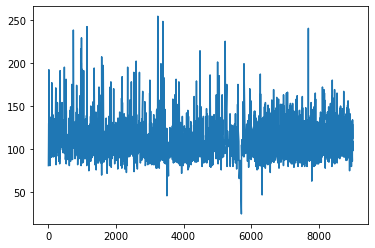

In [95]:
plt.plot(dfm_cluster.runtime)

In [96]:
cluster_features = cluster_features[cluster_features.runtime >= 40]
cluster_features = cluster_features[cluster_features.runtime <= 240]

On regarde la proportion de films pour lesquels certains champs n'ont pas été renseignés.

In [97]:
print("Nombre de films retenus dans cluster_features : ", len(cluster_features))
print("Parmi ces films :")
print(len(cluster_features[cluster_features.genres == "[]"]), "n'ont pas de genres")
print(len(cluster_features[cluster_features.keywords == "[]"]), "n'ont pas de keywords")
print(len(cluster_features[cluster_features.production_countries == "[]"]), "n'ont pas de production_countries")
print(len(cluster_features[cluster_features.crew == "[]"]), "n'ont pas de crew")

Nombre de films retenus dans cluster_features :  3390
Parmi ces films :
1 n'ont pas de genres
110 n'ont pas de keywords
24 n'ont pas de production_countries
0 n'ont pas de crew


Il s'agit d'une petite proportion, on peut donc retirer ces films problématiques.

In [98]:
cluster_features = cluster_features[cluster_features.genres != "[]"]
cluster_features = cluster_features[cluster_features.keywords != "[]"]
cluster_features = cluster_features[cluster_features.production_countries != "[]"]
print("Nombre de films dans cluster_features : ", len(cluster_features))

Nombre de films dans cluster_features :  3265


On peut maintenant se concentrer sur le traitement des données de chacune des colonnes. Il faut les simplifier au maximum pour rendre possible la comparaison de films basée sur ces attributs.

In [99]:
def vectorize_genres(genres):
    
    if isinstance(genres, str):
        pattern = re.compile(r"'id': [0-9]*")
        return np.array([int(w[6:]) for w in pattern.findall(genres)])
    
    return genres

In [100]:
cluster_features.genres = cluster_features.genres.apply(vectorize_genres)

In [101]:
def vectorize_keywords(keywords):
    
    if isinstance(keywords, str):
        pattern = re.compile(r"'id': [0-9]*")
        return np.array([int(w[6:]) for w in pattern.findall(keywords)])
    
    return keywords

In [102]:
cluster_features.keywords = cluster_features.keywords.apply(vectorize_keywords)

In [103]:
def find_director(crew):
    
    if isinstance(crew, str):
        start = crew.find('\"Director\"')+21
        new = crew[start:]
        end = new.find("\"")
        director = new[:end]
        return director
    
    return crew

In [104]:
cluster_features = cluster_features.rename(columns={'crew' : 'director'})
cluster_features.director = cluster_features.director.apply(find_director)

In [105]:
def simplify_date(date):
    
    if isinstance(date, str):
        return int(date[:4])
    
    return date

In [106]:
cluster_features.release_date = cluster_features.release_date.apply(simplify_date)

In [124]:
def simplify_countries(countries):
    
    if isinstance(countries, str):
        pattern = re.compile(r"'iso_3166_1': ...")
        return [w[15:] for w in pattern.findall(countries)]
    
    return countries

In [108]:
cluster_features.production_countries = cluster_features.production_countries.apply(simplify_countries)

In [109]:
cluster_features.head()

,title,movieId,genres,keywords,director,release_date,production_countries,original_language,runtime
0,Toy Story,1,"[16, 35, 10751]","[931, 4290, 5202, 6054, 9713, 9823, 165503, 17...",John Lasseter,1995,[US],en,81.0
9,GoldenEye,10,"[12, 28, 53]","[701, 769, 1308, 2812, 3268, 3272, 3278, 3376,...",Martin Campbell,1995,"[GB, US]",en,130.0
10,The American President,11,"[35, 18, 10749]","[833, 840, 1605, 33476, 211505]",Rob Reiner,1995,[US],en,106.0
13,Nixon,14,"[36, 18]","[840, 2946, 4240, 5565, 6086, 6165]",Oliver Stone,1995,[US],en,192.0
14,Cutthroat Island,15,"[28, 12]","[911, 1454, 1969, 3799, 5470, 12988]",Renny Harlin,1995,"[FR, DE, IT, US]",en,119.0


### Définition d'une distance sur les films

In [73]:
MAX_YEAR_DIFFERENCE = max(cluster_features.release_date) - min(cluster_features.release_date)
MAX_RUNTIME_DIFFERENCE = max(cluster_features.runtime) - min(cluster_features.runtime)

Cette fonction calcule les similarités entre 2 films. Plus les valeurs sont proches de 0, plus les films ont de points communs et plus elles sont proches de 1, plus ils sont différents (peut-être changer le nom ? instinctivement, j'aurais pensé que pour être très similaire il fallait un score élevé REPONSE : il s'agit d'une distance)

discuter de la manière de les calculer ?

In [74]:
def movie_distance(m1, m2, w_gen=3, w_key=4, w_dir=4, w_rel=2, w_pro=2, w_ori=1, w_run=1):
    
    sum_vect = 0
    # SIMILARITIES IN GENRES
    g1 = m1.genres
    g2 = m2.genres
    gen = np.append(g1, g2)
    sum_vect += (w_gen * (1 - (len(gen) - len(np.unique(gen))) / min(len(g1), len(g2)))) ** 2
        
    # SIMILARITIES IN KEYWORDS
    kw1 = m1.keywords
    kw2 = m2.keywords
    kw = np.append(kw1, kw2)
    sum_vect += (w_key * (1 - (len(kw) - len(np.unique(kw))) / min(len(kw1), len(kw2)))) ** 2
    
    # SIMILARITIES FOR THE DIRECTOR
    if m1.director != m2.director:
        sum_vect += (w_dir * 1) ** 2  # CHANGER PEUT ETRE
        
    #SIMILARITIES FOR THE RELEASE DATE
    sum_vect += (w_rel * abs(m1.release_date - m2.release_date) / MAX_YEAR_DIFFERENCE) ** 2
    
    #SIMILARITIES IN PRODUCTION COUNTRIES
    pc = []
    pc1 = m1.production_countries
    pc.extend(pc1)
    pc2 = m2.production_countries
    pc.extend(pc2)
    pc_dist = 1 - (len(pc) - len(np.unique(pc))) / min(len(pc1), len(pc2))
    if 'US' not in pc1 and 'US' not in pc2 and pc_dist > 0.5:
        sum_vect += (w_pro * 0.5) ** 2
    else:
        sum_vect += (w_pro * pc_dist) ** 2
    
    #SIMILARITIES FOR THE LANGUAGE
    lang1 = m1.original_language
    lang2 = m2.original_language
    if lang1 != lang2 :
        if lang1 != 'en' and lang2 != 'en':
            sum_vect += (w_ori * 0.4) ** 2
        else:
            sum_vect += (w_ori * 1) ** 2
    
    #SIMILARITIES FOR THE RUNTIME
    sum_vect += (w_run * abs(m1.runtime - m2.runtime) / MAX_RUNTIME_DIFFERENCE) ** 2
    
    return np.sqrt(sum_vect)

La fonction compute_dist_matrix calcule la distance séparant chaque paire de films du DataFrame passé en argument. Cependant elle ne renvoit pas une matrice, mais un pd Series avec un double index (l'id de 2 films).

In [75]:
def compute_dist_matrix(clu_fea):
    
    movies_id = clu_fea.movieId.apply(lambda x: str(x))
    dist_mat = pd.DataFrame(np.nan * len(clu_fea), index=movies_id, columns=movies_id)
    for i in range(len(clu_fea)):
        for j in range(i, len(clu_fea)):
            if i == j:
                dist_mat.iat[i, j] = 1000
            else:
                dist_mat.iat[i, j] = dist_mat.iat[j, i] = movie_distance(clu_fea.iloc[i], clu_fea.iloc[j]) # ICI
    
    return dist_mat

On s'intéresse ici au Agglomerative Hierarchical Clustering. On n'a pas besoin de préciser le nombre de clusters attendus, à la place on obtient un dendrogramme.

In [76]:
class dendrogram:
    def __init__(self, leaf=None):
        self.leaf = leaf
        self.leaf_nb = 1
        self.father = None
        self.left = None
        self.right = None
    
    def set_leaf_nb(self):
        total_leaf_nb = 0
        if self.left is not None:
            total_leaf_nb += self.left.leaf_nb
        if self.right is not None:
            total_leaf_nb += self.right.leaf_nb
        self.leaf_nb = max(1, total_leaf_nb)
    
    def get_id_list(self):
        id_list = []
        def prefix(node):
            if node.leaf is not None:
                id_list.append(node.leaf)
            else:
                prefix(node.right)
                prefix(node.left)
        prefix(self)
        
        return id_list
    
    def get_root(self):
        tmp = self
        while tmp.father is not None: tmp = tmp.father
            
        return tmp
    
    def get_n_clusters(self, n):
        cluster_list = []
        outliers = []
        error = []
        def step(node, n):
            if n == 1:
                cluster_list.append(node.get_id_list())
            elif node.left is None or node.right is None:
                error.append(True)
            else:
                prop_left = node.left.leaf_nb / node.leaf_nb
                prop_right = node.right.leaf_nb / node.leaf_nb
                if prop_left < 0.15:
                    outliers.extend(node.left.get_id_list())
                    step(node.right, n)
                elif prop_right < 0.15:
                    outliers.extend(node.right.get_id_list())
                    step(node.left, n)
                else:
                    n_left = max(1, round(n * prop_left))
                    if n_left == n:
                        n_left -= 1
                    n_right = n - n_left
                    step(node.left, n_left)
                    step(node.right, n_right)
        step(self, n)
        if error:
            print("n too big")
        else:
            return cluster_list, outliers

On ajoute un attributs dendrogram aux films sélectionnés. Au départ, chaque film est isolé. Ensuite on construit le dendrogramme étape par étape en connectant les films les plus proches (on les regroupe dans un même cluster).

In [78]:
def clusterize(dist_mat, clu_fea):
    
    clu_fea["dendrogram"] = clu_fea.movieId.apply(lambda x: dendrogram(leaf=x))
    size_mat = len(clu_fea)
    for cpt in range(1, size_mat):
        index_str1, index_str2 = dist_mat.stack().idxmin()
        index1, index2 = int(index_str1), int(index_str2)
        mov1 = clu_fea[clu_fea.movieId == index1].iloc[0]
        mov2 = clu_fea[clu_fea.movieId == index2].iloc[0]
        tmp1 = mov1.dendrogram
        tmp2 = mov2.dendrogram
        while tmp1.father is not None: tmp1 = tmp1.father
        while tmp2.father is not None: tmp2 = tmp2.father
        tmp3 = dendrogram()
        tmp3.left = tmp1
        tmp3.right = tmp2
        tmp3.set_leaf_nb()
        tmp1.father = tmp3
        tmp2.father = tmp3
        new_d = np.maximum(dist_mat.loc[index_str1, :], dist_mat.loc[index_str2, :])
        dist_mat.loc[index_str1, :] = dist_mat.loc[:, index_str1] = new_d
        dist_mat = dist_mat.drop(index_str2, axis=0)
        dist_mat = dist_mat.drop(index_str2, axis=1)
    
    return clu_fea.iloc[0].dendrogram.get_root()

In [79]:
def get_cluster(clu_fea, id_list):
    df = pd.DataFrame([])
    for i in id_list:
        df = df.append(clu_fea[clu_fea.movieId == i])
    
    return df

In [81]:
def get_clusters_size(clu_fea, id_list_list):
    for id_list in id_list_list:
        print(len(id_list))

Test sur un échantillon de taille 10

In [83]:
test_10 = cluster_features.sample(10)
start_time = time()
dist_mat_test_10 = compute_dist_matrix(test_10)
print("Temps d'execution : %s secondes ---" % (time() - start_time))

Temps d'execution : 0.24024415016174316 secondes ---


In [87]:
start_time = time()
root_test_10 = clusterize(dist_mat_test_10.copy(), test_10)
print("Temps d'execution : %s secondes ---" % (time() - start_time))

Temps d'execution : 0.25934696197509766 secondes ---


Test sur un échantillon de taille 100

In [89]:
test_100 = cluster_features.sample(100)

In [90]:
start_time = time()
dist_mat_test_100 = compute_dist_matrix(test_100)
print("Temps d'execution : %s secondes ---" % (time() - start_time))

Temps d'execution : 31.048837900161743 secondes ---


In [91]:
#%lprun -f movie_distance compute_dist_matrix(test_100)

In [92]:
start_time = time()
root_test_100 = clusterize(dist_mat_test_100.copy(), test_100)
print("Temps d'execution : %s secondes ---" % (time() - start_time))

Temps d'execution : 4.242453098297119 secondes ---


In [93]:
#%lprun -f clusterize clusterize(dist_mat_test_100.copy(), test_100)

In [94]:
clusters, outliers = root_test_100.get_n_clusters(5)
print(len(outliers), 'outliers')
get_clusters_size(cluster_features, clusters)

4 outliers
15
10
19
28
24


In [95]:
get_cluster(cluster_features, outliers)

,title,movieId,genres,keywords,director,release_date,production_countries,original_language,runtime
3358,Exit Wounds,4224,"[28, 80, 53]","[417, 3692, 4918, 6149]",Andrzej Bartkowiak,2001,"[CA, US]",en,101.0
1177,Absolute Power,1459,"[80, 18, 53]","[417, 441, 521, 570, 833, 840, 5600, 6086, 993...",Clint Eastwood,1997,[US],en,121.0
1727,Frenzy,2178,"[80, 18, 9648, 53]","[212, 570, 6149, 9937, 10714]",Alfred Hitchcock,1972,[GB],en,116.0
3352,River's Edge,4218,"[80, 18]","[572, 6149, 9713, 9826]",Tim Hunter,1986,[US],en,99.0


Données complètes

In [98]:
start_time = time()
dist_mat = compute_dist_matrix(cluster_features) # environ 45 minutes
print("Temps d'execution : %s secondes ---" % (time() - start_time))

KeyboardInterrupt: 

In [ ]:
start_time = time()
root = clusterize(dist_mat, cluster_features) # environ 15 minutes
print("Temps d'execution : %s secondes ---" % (time() - start_time))

In [ ]:
clusters, outliers = root.get_n_clusters(8)
print(len(outliers), 'outliers')
get_clusters_size(cluster_features, clusters)

In [ ]:
get_cluster(cluster_features, outliers)

## Model-based recommendation system

La matrice des notes user-item $R$ est partiellement vide. Ainsi réduire les dimensions de la matrice pourrait améliorer la complexité de nos algorithmes. Une méthode que nous pourrions avoir envie d'utiliser est la décomposision en valeurs singulières : $R = U_{svd} \Sigma V_{svd}$. Cependant cette méthode ne s'applique pas ici étant donné que $R$ n'est pas complète et qu'on a besoin de réaliser des calculs algébriques avec $R$ pour trouver la décomposition.

On considère donc un modèle dans lequel il existe des attributs décrivants les films et les préférences des utilisateurs. La matrice $R$ peut alors être factorisée en produit de deux matrices $U$ et $V$ représentant respectivement les utilisateurs et les items :

$$
R \approx U \times V^T
$$

avec $R \in \mathbb{R}^{n \times m}$ la matrice des notes user-item, $U \in \mathbb{R}^{n \times \ell}$ la matrice des users, $V \in \mathbb{R}^{m \times \ell}$ la matrice des items et $\ell$ le nombre d'attributs. Pour faire un rapprochement avec la SVD, on peut considerer que $U = U_{svd} \Sigma^{1/2}$ et $V = \Sigma^{1/2} V_{svd}$. On note $U_i$ les lignes de $U$ et $V_j$ les lignes de $V$ :
$
U = \left[ \begin{array}{c} U_1 \\ \vdots \\ U_n \end{array} \right]
$ et 
$
V = \left[ \begin{array}{c} V_1 \\ \vdots \\ V_m \end{array} \right]
$
avec $U_i^T, V_j^T \in \mathbb{R^\ell}$.

Dans ce modèle, chaque note $R_{ij}$ associée à un couple user-item $(i, j)$ est le résultat du produit scalaire entre la ligne associée au user $i$ dans $U$ et la ligne associée au item $j$ dans $V$ : $R_{ij} = U_i \cdot V_j^T$. Une fois les matrices $U$ et $V$ apprises, pour prédire une note il suffira de faire le produit scalaire entre les lignes associées.

Trouver $U$ et $I$ revient à minimiser l'erreur entre la note prédite $U_i \cdot V_j^T$ et la véritable note $R_{ij}$. Il s'agit du problème de minimisation suivant, avec $E = \{(i, j) \mbox{ | } R_{ij} \mbox{ connue}\}$ :

$$
(U, V) = argmin_{(U, V)} \sum_{(i, j) \in E} [U_i \cdot V_j^T - R_{ij}]^2
$$

qui est équivalent à:

$$
(U, V) = argmin_{(U, V)} \frac{1}{2}\sum_{(i, j) \in E} [U_i \cdot V_j^T - R_{ij}]^2 + \lambda (\|U_i\|^2 + \|V_j\|^2)
$$

Le terme de droite est un terme régulateur, de paramètre $\lambda$ à ajuster, permettant de prévenir un overfitting.

Pour résoudre ce problème, nous allons utiliser une méthode de descente de gradient.


*Pour résoudre ce problème, on peut utiliser une méthode de descente de gradient. Nous allons ensuite optimiser cette méthode en utilisant d'abord des batch, puis en se réduisant à un problème de moindre carré en fixant alternativement les matrices $U$ et $V$.*

### Descente de gradient (à pas constant)

Dans notre [cours d'optimisation](https://www.ceremade.dauphine.fr/~gontier/enseignement.html) donné par David Gontier, nous avons étudié différentes méthodes de descente de gradient de complexité et d'optimalité différentes. Cependant il nous semble qu'utiliser une version simple à pas $\tau$ constant suffit. Il sera possible de régler cet hyper-paramètre par validation croisée. 

Notre fonction objective est la suivante :
$$
F(U, V) := \sum_{(i, j) \in E} \frac{1}{2}[U_i \cdot V_j^T - R_{ij}]^2 + \frac{\lambda}{2} (\|U_i\|^2 + \|V_j\|^2)
$$

Dans une descente de gradient classique, à chaque itération on met à jour $U$ et $V$ suivant la formule 
$
(U, V) = (U, V) - \tau \nabla F(U, V)
$. Cependant, dans notre cas nous n'allons pas mettre à jour toutes les lignes de $U$ et $V$ simultanément. En effet, puisque la somme dans $F$ ne se fait que sur les couples $(i, j)$ pour lesquels la note est connue, nous allons seulement mettre à jour le couple $(U_i, V_j)$ associé en itérant sur tous les couples $(i, j) \in E$. 

Pour une note $R_{ij}$, on a 
$
\frac{\partial F}{\partial U_i} = V_j^T (U_i \cdot V_j^T - R_{ij}) + \lambda U_i
$
 et 
$
\frac{\partial F}{\partial V_j} = Ui (U_i \cdot V_j^T - R_{ij}) + \lambda V_j
$
donc on peut mettre à jour les lignes $U_i$ et $V_j$ selon les formules 
$$
U_i = Ui - \tau [V_j^T (U_i \cdot V_j^T - R_{ij}) + \lambda U_i]\\
V_j = V_j - \tau [Ui (U_i \cdot V_j^T - R_{ij}) + \lambda V_j]
$$

In [ ]:
dfr = ratings.copy()
user_rank = dfr.userId.unique().tolist()
movie_rank = dfr.movieId.unique().tolist()
R = [ratings.loc[ratings['userId'] == user, ['rating']].to_numpy() for user in user_rank]

In [ ]:
R.head()

In [ ]:
n = len(R.userId.unique())
m = len(R.movieId.unique())
print('n:', n, 'm:', m)

In [ ]:
a = R.movieId.unique()
a.sort()
print(a)
R.userId.unique()[:100]

Il se peut que tous les entiers entre 1 et $n$ (ou $m$) ne soient pas utlisés par les id des users (ou des movies). Ceci est par exemple le cas lorsqu'on travaille avec un échantillon des données. Puisque nous aimerions utiliser des numpy array dans nos calculs, il va être nécessaire d'avoir la correspondant entre les id et les indices utilisés dans les numpy array (que nous allons appeler rang). Pour cela, utilisons simplement une liste contenant les id et dont l'indice dans la liste d'un id donné correspondra au rang. Pour trouver l'id à partir d'un rang il suffira de faire un simple extraction, pour trouver le rang à partir d'un id on utilisera la méthode `index()`.

In [ ]:
user_rank = R.userId.unique().tolist()
movie_rank = R.movieId.unique().tolist()

La matrice $R$ étant vide, nous n'allons pas utiliser de matrice pour la représenter et garderons la dataframe qui ne contient que les notes connues. Nous allons également avoir besoin d'écrire une fonction `get_rat()` qui permet d'accéder à la note d'un couple de rang dans la dataframe des notes. Nous utilisons également une fonction `known()` pour construire l'ensemble $E$.

# <span style="color:green"> Comparer si get_rat plus efficace avec R une dataframe ou R un numpy matrix </span>

In [ ]:
def get_rat(R, i, j):
    '''
    Retourne la note de rang (i, j) dans la dataframe R
    '''
    uid, mid = user_rank[i], movie_rank[j]
    return float(R.loc[(R['userId'] == uid) & (R['movieId'] == mid), 'rating'])

In [ ]:
def known(R):
    '''
    Retourne l'ensemble des indices (i, j) pour lesquels la note est connue dans R
    '''
    ids = set(R.loc[:, ['userId', 'movieId']].itertuples(index=False, name=None))
    E = set(map(lambda t : (user_rank.index(t[0]), movie_rank.index(t[1])), ids ))
    return E

Nous pouvons à présent écrire la fonction résolvant notre problème de minimisation. Remarquons qu'elle modifie les valeurs de $U$ et $V$ en place.

# <span style="color:green"> Condition d'arrêt de la descente : prends trop de temps à calculer </span>

In [ ]:
def compute_rmse(U, V, E):
    predicted = np.dot(U, V.T) # the predicted rating matrix
    
    rmse = 0
    nb_instances = 0
    for (i, j) in E :
        rmse += (predicted[i, j] - get_rat(R, i, j)) ** 2 
        nb_instances += 1
    return np.sqrt(rmse / nb_instances)

In [ ]:
def descenteGradient(U, V, tau, tol=1e-3, Niter=100, verbose=False):
    E = known(R)
    last_rmse = 0
    
    if verbose:
        logger = logging.getLogger()
        logger.setLevel(logging.INFO)
        logging.info('nombre de couples : {}'.format(len(E)))

    for n in range(Niter):
        if verbose :
            logging.info("iteration: {}".format(n))
            logging.info('compute rmse')
        
        rmse = compute_rmse(U, V, E)
        if abs(rmse - last_rmse) < tol:
            return U, V
        last_rmse = rmse

        if verbose:
            logging.info('update U and V')
        
        n_couple = 0
        for (i, j) in E :
            if verbose and not n_couple % 10000:
                logging.info("couple number: {}".format(n_couple))
            n_couple += 1
    
            gradU = V[j].T * (np.dot(U[i], V[j].T) - get_rat(R, i, j)) + lamb * U[i]
            gradV = U[i] * (np.dot(U[i], V[j].T) - get_rat(R, i, j)) + lamb * V[j]
            U[i] = U[i] - tau * gradU
            V[j] = V[j] - tau * gradV
    print("Erreur, l’algorithme n’a pas convergé après", Niter ," itérations")
    return U, V

In [ ]:
# hyper-paramètres à tuned
ell = 10
tau = 1/10
lamb = 1/2
U, V = np.random.rand(n, ell), np.random.rand(m, ell)
print(U[:5, :5])
print(V[:5, :5])

In [ ]:
t1 = time()
descenteGradient(U, V, tau, verbose=True)
t2 = time()
print(t2-t1)

In [ ]:
t1 = time()
rmse = compute_rmse(U, V, known(R))
t2 = time()
print(t2-t1)
print(rmse)

In [ ]:
def predict_model(uid, mid):
    user = user_rank[uid]
    movie = movie_rank[mid]
    return np.dot(U[user], V[movie].T)

In [ ]:
user = 3
movie = 4

print(predict_model(user, movie))

### Cross-validation


## Linear model : content-based

On remarque que si $U$ ou $V$ est fixé, la fonction objective devient quadratique. Or nous connaissons des algorithmes efficaces pour minimiser des fonctions quadratiques. De plus, une matrice d'attributs des films peut être donnée puisqu'on connaît certaines informations sur les films.